**HAVING PREVIOUSLY USED MOBILENET, NOW USE COCO SSD**

*This part has ImageDraw, ImageFont imported from PIL to draw bounding boxes over detected objects with Coco.*

Use Tensorflow Lite for predictions with an off-the-shelf deep-learning model. The model architecture and weights are pre-determined. Use the ```Interpreter``` class from ```tflite_runtime``` that has only this class. 
1. Find the download link [here](https://dl.google.com/coral/python/tflite_runtime-1.14.0-cp37-cp37m-linux_armv7l.whl) for Python 3.7. 
2. Install with pip3 installer, pointing to the local copy of the '.whl' file. 
3. Verify by opening python kernel and typing ```from tflite_runtime.interpreter import Interpreter```.

Now, proceed with the script.

In [54]:
from tflite_runtime.interpreter import Interpreter
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import time
import os
from picamera import PiCamera
from io import BytesIO
import matplotlib.pyplot as plt

In [62]:
model = "COCO" # MobileNet

*This part substitutes the two files that are the source of model parameters and text labels for the cnn.*

The ```Interpreter``` class makes predictions with a pre-trained model that is in the format required for Tensorflow Lite. These models conform to an architecture that is among the deep-learning staples, such as, MobileNet. However, this constraint need not be very limiting. It is possible to tinker with and tweak such a model based on neural transfer learning using a service like Google's [Teachable Machine](https://teachablemachine.withgoogle.com).

For this exercise, download the [MobileNet](https://storage.googleapis.com/download.tensorflow.org/models/tflite/mobilenet_v1_1.0_224_quant_and_labels.zip) Convolutional Neural Network (CNN). The zip archive has two files as follows: (1.) The set of weights (a.k.a serialized model) (2.) The category labels for classification. The weights are represented with 8-bits each so that the model trades off precision for lower storage, thus taking up less memory for computation.

Let's get set up to load the model components extracted from the archive.

In [63]:
data_source = '/home/pi/Downloads/CocoSSD'

path2model = os.path.join(data_source, 'detect.tflite') # mobilenet_v1_1.0_224_quant
path2labels = os.path.join(data_source, 'labelmap.txt') # labels_mobilenet_quant_v1_224

print("{} labels saved locally at {}.".format("CONFIRMED" \
    if os.path.exists(path2labels) else "NOT FOUND", path2labels))
print("{} model saved locally at {}.".format("CONFIRMED" \
    if os.path.exists(path2model) else "NOT FOUND", path2model))

CONFIRMED labels saved locally at /home/pi/Downloads/CocoSSD/labelmap.txt.
CONFIRMED model saved locally at /home/pi/Downloads/CocoSSD/detect.tflite.


*This part tweaks the process of importing labels to address the nonsensical '???' that may occur.*

Let's load the category labels and examine the top 5 categories.

In [64]:
with open(path2labels) as text_labels:
    labels = text_labels.readlines()
labels = [label.rstrip() for label in labels]
if labels[0] == '???':
    del(labels[0])
labels[0:7]

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train']

*This part is the same for MobileNet and Coco.*

Let's load the weights and allocate tensors.

In [65]:
interpreter = Interpreter(path2model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]["shape"][1]
width = input_details[0]["shape"][2]

*This part adds the type of pixel (float or 8-bit unsigned int) in the write-out. When float, additional pre-conditioning of the input to normalize it is required. TODO!*

The model expects an input image in certain shape. Let's examine. We will get our images into the shape required by the model later.

In [66]:
print("Use an input image of size {} x {} and type {} in {}-D.".format(height, width, \
    "float" if (input_details[0]["dtype"] == np.float32) else "int", \
        len(input_details[0]["shape"])))

Use an input image of size 300 x 300 and type int in 4-D.


*This part adjusts for the size of the image (width and height) for Coco.*

Now that we know the dimensions, let's prepare an image to use in classification. We will take a picture with picamera first. Let's set up the picamera. Note that the code in the cell (below) must be run only once or otherwise, restart the kernel and run the notebook starting over.

In [67]:
"""
eye_stream = BytesIO()

eye = PiCamera()
eye.rotation = 180
eye.resolution = (300, 300)

time.sleep(2)  # Warm up

eye.capture(eye_stream, 'jpeg')
eye_stream.seek(0)
snap = Image.open(eye_stream).convert('RGB').resize((height, width))
snap.show()
"""

"\neye_stream = BytesIO()\n\neye = PiCamera()\neye.rotation = 180\neye.resolution = (300, 300)\n\ntime.sleep(2)  # Warm up\n\neye.capture(eye_stream, 'jpeg')\neye_stream.seek(0)\nsnap = Image.open(eye_stream).convert('RGB').resize((height, width))\nsnap.show()\n"

Capture an image from the byte stream and resize for feeding to the classifier.

In [68]:
def take_snap(width, height):
    with PiCamera() as Eye:
        Eye.rotation = 180
        Eye.resolution = (512, 512)
        with BytesIO() as Stream:
            Eye.capture(Stream, 'jpeg')
            Stream.seek(0)
            snap = Image.open(Stream).convert('RGB').resize((height, width))
            snap.show()
            return snap

# Usage: test_snap = take_snap(224, 224)

In [69]:
def showsnap(snap, title='', label=''):
    # Show in notebook
    font = {'family': 'serif', 'color': 'red', 'size': 18}
    plt.imshow(snap)
    plt.xticks([])
    plt.yticks([])
    plt.title(title, fontdict=font)
    if not label:
        plt.xlabel(" x ".join("{}".format(i) for i in np.array(snap).shape), fontdict=font)
    plt.show()

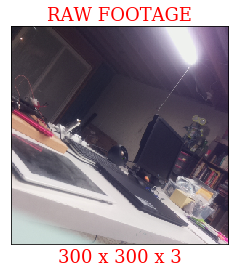

In [70]:
snap = take_snap(300, 300) # 224, 224
showsnap(snap, 'RAW FOOTAGE')

*This part does not change for MobileNet and Coco.*

Now, set the tensor to feed the image to the deep-learning model for image classification. Call the ```invoke()``` method to propagate the input through the layers of the CNN in feed-forward mode. The feed-forward mode consists of a sequence of linear algebraic steps, chiefly matrix multiplication. In the process, the input image is subject to a filter bank in the form of image convolutions to extract primitive patterns, followed by revealing the structure of shapes and textures in the image based on compositions of these primitives. This leads to detection of objects in the physical world that are represented in images as particular combinations of shapes and texture "known" to the model from its learning process.

Obtain details about the input tensor by querying the interpreter using the ```get_input_details()``` method. Then use the ```set_tensor()``` method with the index in the input details to set the input tensor for prediction. Likewise, get details about the output by using the ```get_output_details()``` method. Then use ```get_tensor()``` with the index in output details and proceed to access and condition results. 

Line no. 1, add an axis to the input image as the model expects a set of images with axis 0 being the demarcator. Line no. 2, supply the input image at the correct index. Line no. 3, execute a feed-forward run for prediction. 

In [71]:
im2classify = np.expand_dims(snap, axis=0)
interpreter.set_tensor(input_details[0]["index"], im2classify)
interpreter.invoke()

*This part has significant changes for richer analysis (e.g. bounding boxes) from Coco. This is in line with the higher resources commanded by this model.*

Coco:
Get tensors for detected objects with the class lables, success probabilities and bounding boxes. The inference is based on applying a confidence threshold to the results. The bounding boxes can be drawn on the original surveillance footage with accompanying labels, such as, "person: 72%".

Lines 2 through 4, get the tensors for bounding boxes, class labels and success probabilities. Line no. 7 has the meat of the output, which is, the objects detected with success probability above the configurable threshold. The labels are returned with scores. Note that this method differs slightly from the approach for MobileNet where the top-ranking objects are reported regardless of score. These approaches can be aligned for consistency.

Starting line no. 11, iterate over each object detected to render bounding boxes (line nos. 14 through 22) and affix text labels (lines no. 24 through 28). A bounding box is defined by top-left and bottom-right corner, with numpy array axis 0 indexing the detected objects and the axis 1 indexing the location coordinates in a set order. The coordinates are expressed as percentage of the image dimensions and may exceed the image perimeter, thus requiring that we apply lower or upper bounds to the calculated coordinates in units of pixel to constrain the bounding boxes. Hence the min-max functions in lines 16 through 20.

With PIL graphics, the lines are etched on the original image and cannot be erased. The bounding boxes are envisaged as useful for the purpose of debugging, so this is OK. A future implementation , may start with a copy of surveillance footage. TODO!

MobileNet:
With calculations complete, process the output to extract the top-ranking matches. Line no. 1, get output details. Line no. 3, get raw output using the index in the output details. Drop any axes that have a length of one. (E.g. 3D: 2 x 1 x 2 ~ 2D: 2 x 2). Line nos. 5 and 6 condition the output by scaling. Note that the output before scaling is integer and after scaling is float. The output represents the estimated likelihood of detection of each object in the list that the model is trained to recognize. 

Line no. 9 uses the ```argpartition()``` method of numpy to find the top-rakning hits. This method is computationally suitable for identifying N items larger than the rest in a big array. *It does not return ordered indices.* We have flipped the sign to get the indices of the largest values on the left of the returned array. The variable 'top' specifies how many of the largest values we want. Slice the array 'ordered' returned by argpartition to get the indices of the top matches in no particular order. Then get the labels and likelihoods as an array of tuples using these indices. 

Try ```top=1``` and then with values 2, 3, 4 and 5. Observe that it gives the top 1, 2, 3, 4 and 5 values respectively. 

See [stackoverflow.com post](https://stackoverflow.com/questions/35206101/using-numpy-argpartition).

In [72]:
if model == "COCO":
    boxes = interpreter.get_tensor(output_details[0]['index'])[0] # Bounding box coordinates of detected objects
    classes = interpreter.get_tensor(output_details[1]['index'])[0] # Class index of detected objects
    scores = interpreter.get_tensor(output_details[2]['index'])[0] # Success probabilities of detected objects

    threshold = 0.45
    sample = [(labels[int(classes[i])], "{}%".format(int(scores[i]*100))) for i in range(len(scores)) if scores[i] > threshold]
    print("Found {}".format(sample if (len(sample)>0) else "NONE!"))

    snapbb = ImageDraw.Draw(snap)
    for i in range(len(scores)):
        if ((scores[i] > threshold) and (scores[i] <= 1.0)):

            # Get the bounding box for ith object and draw it
            # Calculate the coordinates in pixel, clipping boxes to image perimeter where required.
            ymin = int(max(1, boxes[i][0] * height)) # Clip to 1 px from edge when required
            xmin = int(max(1, boxes[i][1] * width))
            ymax = int(min(width-1, boxes[i][2] * height))
            xmax = int(min(height-1, boxes[i][3] * width))
            bbox = [(xmin, ymin), (xmax, ymax)]
            print("TL: {:.2f}, {:.2f} BR: {:.2f}, {:.2f}.".format(xmin, ymin, xmax, ymax))
            snapbb.rectangle(bbox, outline="yellow")

            # Make and add labels
            font = ImageFont.truetype(r'./Assets/arial.ttf', 12)
            tloc = (xmin, ymin)
            title = "{}: {}%".format(labels[int(classes[i])], int(scores[i]*100))
            snapbb.text(tloc, title, fill="red", font=font, align="left")

    snap.show()

Found [('bottle', '58%')]
TL: 222.00, 127.00 BR: 270.00, 211.00.


In [73]:
if (model == "MobileNet"):
    output = np.squeeze(interpreter.get_tensor(output_details[0]["index"]))

    scale, zero_point = output_details[0]["quantization"]
    output = scale * (output - zero_point)

    top = 5
    ordered = np.argpartition(-output, top)  # Top n values by index 
    [(labels[i], output[i]) for i in ordered[:top]]

Package the code in functions for use in the envisaged computer vision application. Ref. docstrings for details about each function.

In [19]:
def load_labels(path2labels):
    """
    Load the text file with the canned model into a list.
    Args
    - path2labels is the location (string) of the local copy of the file containing classification labels.
    Returns a list of classification labels.
    """
    with open(path2labels) as text_labels:
        labels = text_labels.readlines()
    return [label.rstrip() for label in labels]    

In [21]:
class_labels = load_labels(os.path.join("/home/pi/Downloads/MobileNet", "labels_mobilenet_quant_v1_224.txt"))
print("1st 5 labels: \n{}".format(class_labels[:5]))

1st 5 labels: 
['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']


In [22]:
def set_input_tensor(interpreter, snap):
    """
    Convert the image from camera to a tensor for feeding to the convolutional neural network.
    Args
    - interpreter is the object of class Interpreter from Tensorflow Lite runtime 
    - snap is the open image from the picamera
    Returns None
    Note that Interpreter is the sole class in the Tensorflow Lite runtime.
    """
    im2classify = np.expand_dims(snap, axis=0)
    interpreter.set_tensor(interpreter.get_input_details()[0]["index"], im2classify)

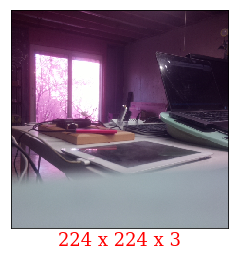

In [25]:
# Pre-work to flesh out blank cnn template with pre-trained weights from file
classifier = Interpreter(os.path.join("/home/pi/Downloads/MobileNet/", "mobilenet_v1_1.0_224_quant.tflite"))
classifier.allocate_tensors()

classifier_input_details = classifier.get_input_details()
classifier_output_details = classifier.get_output_details()
imheight = classifier_input_details[0]["shape"][1]
imwidth = classifier_input_details[0]["shape"][2]

snap = take_snap(imheight, imwidth)
showsnap(snap)

set_input_tensor(classifier, snap)


In [40]:
def predict(interpreter):
    interpreter.invoke()

In [41]:
predict(classifier)

In [42]:
def report_top_matches(interpreter, labels, topk):
    """
    Processes the output to report the top kth matches by probability of success.
    Args
    - interpreter is the object of class Interpreter from Tensorflow Lite runtime
    - topk is an integer specifying the desired rank of the match
    Returns a tuple with the match ID and raw success probability.
    """
    output_details = interpreter.get_output_details()

    output = np.squeeze(interpreter.get_tensor(output_details[0]["index"]))
    scale, zero_point = output_details[0]["quantization"]
    output = scale * (output - zero_point)

    ordered = np.argpartition(-output, topk)
    return [(labels[i], output[i]) for i in ordered[:topk]]

In [43]:
prediction = report_top_matches(classifier, class_labels, 9)
print("Got top matches as: \n{}".format(prediction))

Got top matches as: 
[('laptop', 0.0078125), ('pool table', 0.82421875), ('desk', 0.03515625), ('stage', 0.0234375), ('notebook', 0.01171875), ('quill', 0.01953125), ('paintbrush', 0.0078125), ('projector', 0.0078125), ('swab', 0.0078125)]


In [44]:
def classify_me(interpreter, snap, labels, topk=3):
    set_input_tensor(interpreter, snap)
    predict(interpreter)
    
    return report_top_matches(interpreter, labels, topk)

    

In [45]:

results = classify_me(classifier, snap, labels)
results

[('stage', 0.0234375), ('desk', 0.03515625), ('pool table', 0.82421875)]

## Conclusion
We have tested an approach for offline object detection on Raspberry Pi. The online approach based on calling a web service requires WiFi whereas the offline approach does not. We have overcome issues arising out of compatibility of the Raspberry Pi's the ARM architecture with key computational components as follows:
1. Use PIL for working with image data instead of the pesky OpenCV.
2. Use Tensorflow Lite runtime instead of the full-fledged Tensorflow library. 
3. Use Teachable Machine to tweak thedeep-learning models that apply standard CNN architectures if needed.
We are now poised to add computer vision features to projects such as the smart-seat to prevent infant deaths in a "hot car" and the surveillance system for home security.

## References

[1.] A [guide](https://www.digikey.com/en/maker/projects/how-to-perform-object-detection-with-tensorflow-lite-on-raspberry-pi/b929e1519c7c43d5b2c6f89984883588) to object detection with Tensorflow Lite on Raspberry Pi from DigiKey.